## Calculate moist stability and plot a vertical cross-section

- Figure 9(b) in the paper

In [6]:
import numpy as np
import xarray as xr
import iris

import metpy.calc as mpcalc
import matplotlib.pyplot as plt
%matplotlib inline

### Define the latitude and longitude bounds for the calculation

In [7]:
lon_start = 88.0
lon_end = 130.0
lat_start = 5.5
lat_end = 7.0

height_level = 7000

Tp = 12
time = int(Tp)-12

### Read in N768 MetUM data 

- Analysing a single validity time (T+12 in the paper)

In [8]:
gl_pe='/nobackup/earshar/borneo/case_20181021T1200Z_N768_v2/nc/umglaa_pe{0:03d}.nc'.format(time)
gl_pb='/nobackup/earshar/borneo/case_20181021T1200Z_N768_v2/nc/umglaa_pb{0:03d}.nc'.format(time)

try:    
    input_data_pe = xr.open_dataset(gl_pe).metpy.assign_crs(grid_mapping_name='latitude_longitude',earth_radius=6371229.0) # vertical velocity 
    input_data_pb = xr.open_dataset(gl_pb).metpy.assign_crs(grid_mapping_name='latitude_longitude',earth_radius=6371229.0) # theta + specific humidity
except FileNotFoundError:
    print('File does not exist for specified validity time...')

### Subset N768 MetUM data

In [9]:
# create variable for v_tot (v-wind)
if Tp <= 12: 
    vwind = input_data_pe.v[1,:,:,:].sel(latitude_1=slice(lat_start, 
                                            lat_end)).sel(longitude_1=slice(lon_start, lon_end))
    uwind = input_data_pe.u[1,:,:,:].sel(latitude=slice(lat_start, 
                                            lat_end)).sel(longitude=slice(lon_start, lon_end))
    theta = input_data_pb.theta_1[1,:,:,:].sel(latitude=slice(lat_start,
                                            lat_end)).sel(longitude=slice(lon_start, lon_end))
    q = input_data_pb.q[1,:,:,:].sel(latitude=slice(lat_start,
                                            lat_end)).sel(longitude=slice(lon_start, lon_end))
else:
    vwind = input_data_pe.v.squeeze('t').sel(latitude_1=slice(lat_start, 
                                            lat_end)).sel(longitude=slice(lon_start, lon_end))
    uwind = input_data_pe.u.squeeze('t').sel(latitude=slice(lat_start, 
                                            lat_end)).sel(longitude_1=slice(lon_start, lon_end))
    theta = input_data_pb.theta_1.squeeze('t').sel(latitude=slice(lat_start,
                                            lat_end)).sel(longitude=slice(lon_start, lon_end))  
    # q = input_data_pb.q[1,:,:,:].sel(latitude=slice(lat_start,
    #                                         lat_end)).sel(longitude=slice(lon_start, lon_end))

### Interpolate to evenly spaced levels before calling metpy function

In [10]:
new_ht_levels = theta['hybrid_ht'].data.astype('int32')

theta = theta.interp(hybrid_ht=new_ht_levels,
                    method="linear").assign_coords(height_levels=("hybrid_ht",
                    new_ht_levels)).swap_dims({"hybrid_ht":
                                                "height_levels"
                                                }
                                                )

q = q.interp(hybrid_ht=new_ht_levels,
                    method="linear").assign_coords(height_levels=("hybrid_ht",
                    new_ht_levels)).swap_dims({"hybrid_ht":
                                                "height_levels"
                                                }
                                                )

### Set up arrays for vertical cross section plots

In [11]:
theta = theta.sel(latitude=lat_start, method='nearest').sel(height_levels=slice(50, 15000))
q = q.sel(latitude=lat_start, method='nearest').sel(height_levels=slice(50, 15000))

### Calculate moist stability 

- First calculate static stability
- Moist stability = specific humidity / static stability

In [12]:
d_theta_dz = mpcalc.first_derivative(theta, axis=0)
d_theta_dz = d_theta_dz * (9.81 / theta)
moist_stability = q / d_theta_dz
moist_stability_new = q * d_theta_dz * 10000000.

### Read in SGT tool data, and create variable for v_geo (geostrophic component of v-wind)

In [13]:
sgt_run = 'diab'
sgt_path = f"/nobackup/earshar/borneo/SGTool/N768/oct/{sgt_run}/filter_4_8/conv_g7x_v5"
sgt_file_w = f"{sgt_path}/OUT_w_20181021T1200Z_T0{Tp}.nc"
try:
    iris_array_w = iris.load(sgt_file_w)[0]
    w_sgt = xr.DataArray.from_iris(iris_array_w).sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end))
except FileNotFoundError:
    print('File not found, please try again!')

### Process the SGT tool data

- Interpolate onto evenly spaced levels
- Convert from m/s to cm/s (multiply by 100)
- Linearly interpolate onto N768 MetUM grid

In [14]:
w_sgt = w_sgt.assign_coords(height_levels=("model_level_number", 
                                    new_ht_levels)).swap_dims({"model_level_number":"height_levels"})
w_sgt = w_sgt.interp(height_levels=new_ht_levels,method="linear")
w_sgt = w_sgt * 100.
w_sgt = w_sgt.interp(longitude=theta["longitude"],latitude=theta["latitude"],method="linear")

### Interpolate onto evenly spaced vertical height levels before plotting

- Set up array for vertical cross section by ignoring levels above 15 km 

In [15]:
ht_coords = np.arange(0, 15000, 250)
moist_stability_new = moist_stability_new.interp(height_levels=ht_coords,method="linear")
theta = theta.interp(height_levels=ht_coords,method="linear")
w_sgt = w_sgt.interp(height_levels=ht_coords,method="linear")
w_sgt = w_sgt.sel(height_levels=slice(50, 15000) )

### Modify some features of the input array

- Set up longitude coordinate before plotting to avoid whitespace on either edge of the figure
- Set up colour bar 

In [16]:
dl = 0.5; qmin = 0.0; qmax = 20.0; Levels = np.arange(qmin,qmax+dl,dl); Cmap='plasma_r'
cb_label=r'$r\,N^2\,(10^{-7}\,s^{-2})$'

lon_dim = np.arange(np.rint(theta.longitude[0].data),
                    np.rint(theta.longitude[-1].data)+0.25, 0.25)

theta = theta.interp(longitude=lon_dim, method="linear")
moist_stability_new = moist_stability_new.interp(longitude=lon_dim, method="linear")
w_sgt = w_sgt.interp(longitude=lon_dim, method="linear")

### Produce the customised plot and save the output locally

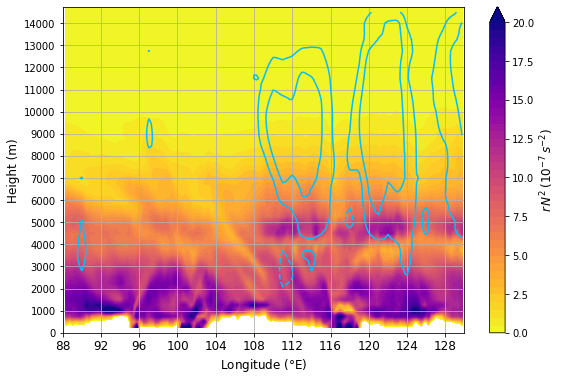

In [17]:
fig = plt.figure(figsize=[9,6])
ax = plt.axes()
ax.grid(True)

xint = 1; yint = 4
if Tp <= 12:
    ts = np.rint(theta.longitude[0].data)
    tf = np.rint(theta.longitude[-1].data)
    dim_size = len(theta.longitude)
else:
    ts = np.rint(theta.longitude[0].data)
    tf = np.rint(theta.longitude[-1].data)
    dim_size = len(theta.longitude)
ax.set_xlabel(r'Longitude ($\degree$E)', fontsize='large')

# set x-axis tickmarks every 4º
ax.set_xlim(0, dim_size-1)
ax.set_xticks(np.arange(0, dim_size+1, 16) )
ax.set_xticklabels(np.arange(int(ts), int(tf+1), yint) , fontsize='large')

# y-axis tickmarks and labels (every 1 km)
mlev_size = len(theta.height_levels)
ax.set_yticks(np.arange(0, mlev_size, 4) )
ax.set_yticklabels(theta.height_levels[::4].data)
ax.set_ylabel('Height (m)', fontsize='large')

# plot cross-section (total wind)
var_contour = plt.contourf(moist_stability_new, levels=Levels, extend='max', cmap=Cmap)

# overlay line contours (vertical velocity)
w_contour = plt.contour(w_sgt, levels=np.arange(-2, 10, 4), colors=['deepskyblue'])

# plot colourbar 
var_cbar = fig.colorbar(var_contour)
var_cbar.set_label(cb_label, fontsize='large')
plt.savefig(f'moist_stability_cross_section_t{Tp}_{str(lat_start)}N_{sgt_run}.png',dpi=200)